In [1]:
import yfinance as yf
from pypfopt import expected_returns, EfficientSemivariance, EfficientFrontier, plotting
from pypfopt.risk_models import risk_matrix
import matplotlib.pyplot as plt
import numpy as np
from pypfopt.expected_returns import capm_return

In [50]:
data = yf.download(['NVDA', 'AMZN'], start='2020-01-01', end='2020-06-01')['Close']
data

[*********************100%%**********************]  2 of 2 completed


,AMZN,NVDA
Date,,
2020-01-02,94.900497,59.977501
2020-01-03,93.748497,59.017502
2020-01-06,95.143997,59.264999
2020-01-07,95.343002,59.982498
2020-01-08,94.598503,60.095001
...,...,...
2020-05-22,121.844002,90.262497
2020-05-26,121.093002,87.177498
2020-05-27,120.519501,85.252502


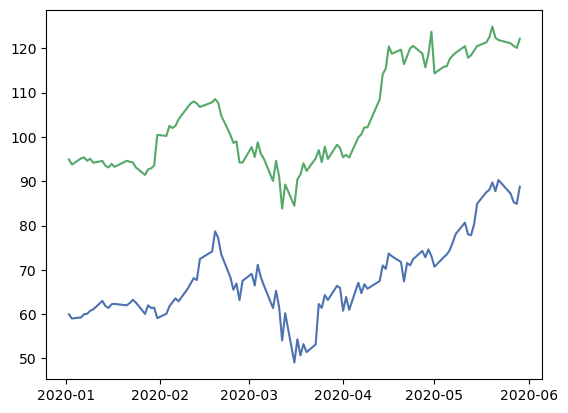

In [3]:
plt.plot(data['NVDA'])
plt.plot(data['AMZN'])

In [4]:
mu = expected_returns.mean_historical_return(data)
historicalReturns = expected_returns.returns_from_prices(data)

In [5]:
mu

AMZN    0.864496
NVDA    1.633329
dtype: float64

In [6]:
historicalReturns

,AMZN,NVDA
Date,,
2020-01-03,-0.012139,-0.016006
2020-01-06,0.014886,0.004194
2020-01-07,0.002092,0.012107
2020-01-08,-0.007809,0.001876
2020-01-09,0.004799,0.010983
...,...,...
2020-05-22,-0.004030,0.028603
2020-05-26,-0.006164,-0.034178
2020-05-27,-0.004736,-0.022081


In [7]:
es = EfficientSemivariance(mu, historicalReturns)
es.efficient_return(0.10)

OrderedDict([('AMZN', 0.9999999270486246), ('NVDA', 7.30566451e-08)])

In [8]:
weights = es.clean_weights()
weights

OrderedDict([('AMZN', 1.0), ('NVDA', 0.0)])

In [9]:
es.portfolio_performance(verbose=True)

Expected annual return: 86.4%
Annual semi-deviation: 28.1%
Sortino Ratio: 3.00


(0.8644960684374443, 0.2810381328982083, 3.00491630700991)

In [10]:
S = risk_matrix(data)
ef = EfficientFrontier(mu, S)
ef

/home/tea/.local/lib/python3.11/site-packages/cvxpy/reductions/solvers/solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


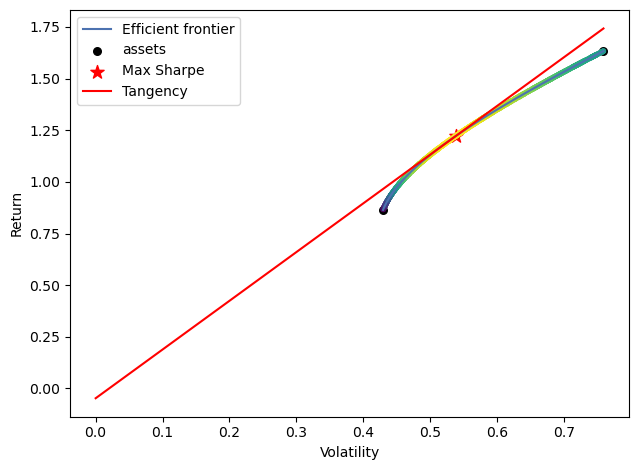

In [11]:
fig, ax = plt.subplots()
efMaxSharpe = ef.deepcopy()
plotting.plot_efficient_frontier(ef, ax=ax)
efMaxSharpe.max_sharpe()
retTangent, stdTangent, _ = efMaxSharpe.portfolio_performance()
ax.scatter(stdTangent, retTangent, marker='*', s = 100, c='r', label='Max Sharpe')

Nsamples = 1024
w = np.random.dirichlet(np.ones(ef.n_assets), Nsamples)
rets = w.dot(ef.expected_returns)
stds = np.sqrt(np.diag(w @ ef.cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker='.', c=sharpes)

X = np.linspace(0, stds.max(), 50)
coefs = np.polyfit([.02, stdTangent], [0, retTangent], 1)
polynomial = np.poly1d(coefs)
Y = polynomial(X)
ax.plot(X, Y, c='r', label='Tangency')
ax.legend()

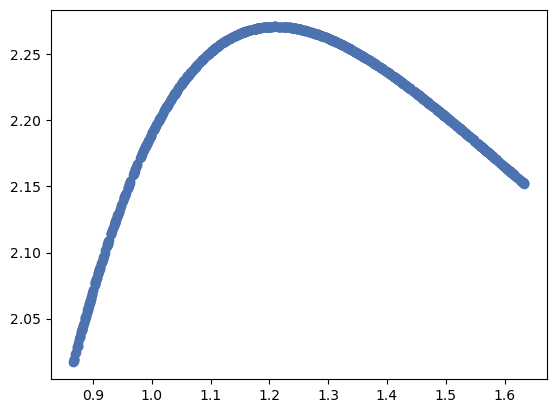

In [12]:
plt.clf()
plt.scatter(rets, sharpes)

In [13]:
efMaxSharpe.portfolio_performance(verbose=True)

Expected annual return: 122.3%
Annual volatility: 53.9%
Sharpe Ratio: 2.23


(1.223033719846639, 0.5385409848981773, 2.2338758861112464)

In [14]:
efMaxSharpe.clean_weights()

OrderedDict([('AMZN', 0.53366), ('NVDA', 0.46634)])